In [1]:
#Scratch work for the conversion of the Bretherton & Sobel Gill model from Matlab to Python
#(transfer to separate script/module once I know it's working)

#Model from paper by Bretherton & Sobel, JAS, 2001.

In [2]:
#Plots don't look right. Why? "fftshift" differences between Python and Matlab?
#Or did I do the sparse matrices wrong?
#I think I have no choice but to print test output from both the Matlab and the Python versions.
#4:30 PM 10-16: realized Numpy and Matlab do FFT on opposite dimensions. So get rid of 
#transpose operators for FFTs. 

In [3]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.linalg import solve #Maybe this will work better than NumPy version for complex matrix?
#Above doesn't work with sparse matrices... could still use todense but there's a better way--
from scipy.sparse.linalg import spsolve

In [22]:
#"User-Defined Parameters": make these inputs to a function

zonalcomp = 0 #No zonal compensation of heating (Original Gill problem)
#  zonalcomp = 1; # Gill problem with zonally compensated heating
nodiss = 0 # Thermal diffusivity = Rayleigh damping (Original Gill problem)
#  nodiss = 1; # Inviscid, no thermal diffusion


#  Set Rayleigh friction (nondimensionalized in units of sqrt(beta*c))
if(nodiss):
    a = 0.0001  # a = 0 would produce divide by zero.
else:
    a = 0.15
#Make this a default flag input
    
#  Define thermal diffusivity b
b = a

#  Define other physical parameters
H = 1.     # Layer depth
g = 1.     # gravity
beta = 1.  # df/dy

#  Domain size and number of mesh points
lx = 20. # periodic domain width -lx/2 < x < lx/2
ly = 20. # Rigid walls at +/- ly/2
nx = 128 # Number of gridpoints in x
ny = 120 # Number of y gridpoints in -ly/2 <= y < ly/2

#  Parameters defining plot window in x,y and stride (in gridpoints) for
#  velocity vector plotting
xmin = -lx/2.
xmax = lx/2.
ymin = -3.5
ymax = 3.5
stride=4
#%----------End of user-defined parameters--------- 


In [23]:
#For debugging: Print all variables 
def printvars(dir):
    for var in dir:
        print(var+':')
        print(eval(var))

In [24]:
#Some preliminary calculations

#Define the grid
dx = lx/nx
x = -lx/2.+dx*np.arange(nx)
dy = ly/ny
y = -ly/2.+dy*np.arange(ny+1)
X,Y=np.meshgrid(x,y)

#Shallow water phase speed
c = np.sqrt(g*H)

#Define mass source M(x,y), derivatives and Fourier transforms
sx = 2. #Mass source half-width in x.   Original: 2
sy = 1. #Mass source half-width in y.   Original: 1
x0 = 0  #Central x of mass source.      Original: 0
y0 = 0.9  #Central y of mass source.      Original: 0

kh = np.pi/(2.*sx)
phase = kh*(X-x0)
phase[X-x0>sx] = np.pi/2.
phase[X-x0<-sx] = np.pi/2.
#for i in range(len(phase)): #To test index assignment worked
#    print(phase[0,i])
F = np.cos(phase)
M = F*np.exp(-(Y-y0)*(Y-y0)/(2*sy*sy))
#print(M)
#print(np.shape(M))
#print(ny)
M[0,:] = 0
M[ny,:] = 0
if zonalcomp == 1: #Replace with boolean True? This should evaluate that way anyway
    M = M - (np.mean(np.transpose(M)))*np.ones([1,nx])
dMdy = -(Y-y0)*M/(sy*sy)
d2Mdy2 = ((Y-y0)*(Y-y0)/(sy*sy)-1)*M/(sy*sy)
#Mhat = np.transpose(np.fft.fft(np.transpose(M)))
Mhat = np.fft.fft(M)
#dMdyhat = np.transpose(np.fft.fft(np.transpose(dMdy)))
dMdyhat = np.fft.fft(dMdy)
#Which axis is FFT being done on? This is a 2D matrix...
#Matlab does FFTs of each column. 
#Numpy uses the last axis, which amounts to the same thing for 2D matrix.
#No--actually "across columns" for NumPy, opposite of Matlab.

#Define wavenumber matrix
#kx = (2*np.pi/lx)*np.concatenate([np.arange(nx/2), np.arange(-nx/2,0)])
kx = (2*np.pi/lx)*np.append(np.arange(nx/2), np.arange(-nx/2,0))
KX = np.ones([ny+1,1])*kx


# #Print stuff from this cell (debug):
# print('X:')
# print(X)
# print('Y:')
# print(Y)
# print('c:')
# print(c)
# print('kh:')
# print(kh)
# print('phase:')
# print(phase)
# print('F:')
# print(F)
# print('M:')
# print(M)
# print('dMdy:')
# print(dMdy)

# d2Mdy2
# Mhat
# dMdyhat
# kx
# KX

In [25]:
#%-------------------Gill computations-----------------------------------------
#This is line 108... another day of work maybe?

#Define v source term Sv = (a*d/dy - beta*y*d/dx)M/H
Svhat = (a*dMdyhat - beta*1j*KX*Y*Mhat)/H #1j is complex number i

# %
# %  Solve (-b(a^2 + beta^2y^2)/c^2 + a*del^2 + beta*d/dx)v = Sv, or
# %
# %  a*d2vhat/dy2 + (-b(a^2 + beta^2y^2)/c^2 -a*k^2 + i*k*beta)vhat = Svhat
# %
# %  where Sv = (a*d/dy - beta*y*d/dx)M/H is the same source term
# %  as in WTG (but this time we don't remove wavenumber zero).

# %  This is done as a loop over wavenumbers, using only the interior 
# %  y-gridpoints 2:ny (since v = 0 at the boundaries)

#vhat = np.zeros([ny+1,nx]) #Need to initialize it as complex to avoid casting to real
vhat = np.zeros([ny+1,nx]) + 1j*np.zeros([ny+1,nx])
d1 = a/(dy*dy)
for i in np.arange(nx):
    k = kx[i]
    d0 = -2*d1 - a*k*k + 1j*k*beta
    #e = np.ones([ny-1,1]) #Don't in Python want this to be column vector--leave 1D for element multiplication
    e = np.ones(ny-1)
    diags = np.stack((d1*e, d0*e-b*(a*a+np.power(beta*y[1:ny],2))/(c*c), d1*e))
    #print(diags) #Confirms diagonals stored row-wise, as required by scipy spdiags
    Av = spdiags(diags, [-1, 0, 1], ny-1, ny-1)
    #print(Av.todense())
    r = Svhat[1:ny,i]
    #vhat[1:ny,i] = Av\r #huh? Backslash operator--matrix left division
    #vhat[  1:ny,i] = np.linalg.solve(Av.todense(),r) #This is the equivalent in Python. It can't handle sparse matrices without converting to dense.
    #vhat[  1:ny,i] = solve(Av,r) 
    vhat[  1:ny,i] = spsolve(Av,r) #imported from scipy.sparse.linalg
    #print(i)
    #print(vhat[40,i])
    #vhat[1:ny,i] = np.linalg.lstsq(Av.todense(),r) #Apparently lstsq should be used instead if A is not square. But A is in fact square...
#v = np.real(np.transpose(np.fft.ifft(np.transpose(vhat))))
v = np.real(np.fft.ifft(vhat))
#print(np.shape(v))    #121, 128
#print(np.shape(Av.todense())) #119, 119
#print(np.shape(r)) #119
#print(Av.todense())

#Could fft be being done on wrong dimension? That would cause errors...


# %  Calculate phi from
# %
# %     (b/c^2)phi + du/dx = M/H - dv/dy 
# %  and
# %     a*u = -dphi/dx + beta*y*v
# %  Eliminating u between these equations,
# %     (a*b/c^2 - d2/dx2)phi = aM/H - a dv/dy - beta*y*dv/dx
# %  whose FFT in x diagnoses phi

#dvdyhat = np.zeros([ny+1, nx])
dvdyhat = np.zeros([ny+1,nx]) + 1j*np.zeros([ny+1,nx])
dvdyhat[1:ny,:] = (vhat[2:ny+1,:]-vhat[0:ny-1,:])/(2*dy)
dvdyhat[0,:] = (vhat[1,:] - vhat[0,:])/dy
dvdyhat[ny,:] = (vhat[ny,:]-vhat[ny-1,:])/dy
phihat = (a*Mhat/H-a*dvdyhat-1j*beta*Y*KX*vhat)/(a*b/(c*c)+KX*KX)
#phi = np.real(np.transpose(np.fft.ifft(np.transpose(phihat))))
phi = np.real(np.fft.ifft(phihat))

D = M/H - b*phi/(c*c)


# %  Calculate vorticity zeta from divergence and v:
# %
# %    a*zeta + beta*(y*D + v) = 0

zeta = (beta/a)*(-Y*D - v)
 
    
#%  u calculated using div eqn: du/dx + dv/dy = M/H-b*phi/(c^2)

dvdy = np.zeros([ny+1,nx]) #This one's supposed to be real I believe
#dvdy = np.zeros([ny+1,nx]) + 1j*np.zeros([ny+1,nx])
dvdy[1:ny,:] = (v[2:ny+1,:] - v[0:ny-1,:])/(2*dy)

#uhat = Mhat/H - b*phihat/(c*c)-np.transpose(np.fft.fft(np.transpose(dvdy)))
uhat = Mhat/H - b*phihat/(c*c)-np.fft.fft(dvdy)
#%   uhat=(Mhat/H-(fft(dvdy.')).');

uhat[:,1:nx] = uhat[:,1:nx]/(1j*KX[:,1:nx])


# %  The k=0 components are indeterminate; for these go to zonally
# %  averaged vorticity equation dudyhat(:,1) = -zetahat(:,1), with BC that
# %  the meridional average of uhat(:,1) should equal zero. 
#zetahat = np.transpose(np.fft.fft(np.transpose(zeta)))
zetahat = np.fft.fft(zeta)
dudyhath = -0.5*(zetahat[0:ny,0] + zetahat[1:(ny+1),0])
uhat[:,0] = np.append(0, dy*np.cumsum(dudyhath))
uhatmean = np.mean(np.append(uhat[1:ny,0], 0.5*(uhat[0,0])+uhat[ny,0]))
uhat[:,0] = uhat[:,0] - uhatmean

#ucompare = np.real(np.transpose(np.fft.ifft(np.transpose(uhat))))
ucompare = np.real(np.fft.ifft(uhat))


#%  u calculated using x momentum eqn: -beta.y.v=-d(phi)/dx-a.u 
dphidx=np.zeros((ny+1,nx)) #This should be real because phi is real

dphidx[:,1:nx-1] = (phi[:, 2:nx] - phi[:,0:nx-2])/(2.*dx)
dphidx[:,0] = (phi[:,1]-phi[:,nx-1])/(2.*dx)
dphidx[:,nx-1] = (phi[:,0] - phi[:,nx-2])/(2.*dx)
u = (-1.*beta*Y*v+dphidx)/(-1.*a)

#This is the end of the general computation section--rest is plotting.
#On 10-15-18 at 3:30 PM: runs up to this point

/home/russotto/miniconda3/envs/pangeo/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [26]:

#####   PLOTS   #####


128
120
4


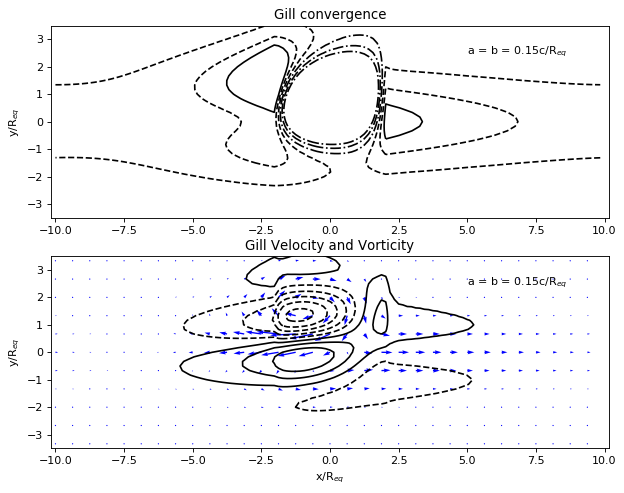

In [27]:
#  if (~nodiss)

# %    figure(1): Plot Gill div and vel/vort
# %    If mass source is compensated (zonalcomp = 1), plot 2 additional figs:
# %     figure(2): WTG div and vel/vort
# %     figure(3): Gill phi and WTG phi
# %    If mass source is compensated and off-equatorial, plot
# %     figure(1): Gill vel/vort and WTG vel/vort

#How to deal with these figure options? Probably best to have one function that does the calculations, and a wrapper that does the plots.
#Can write one wrapper that does what Chris's code does, and others for my own purposes.

#%-------Gill plots--------
plt.figure(1,figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)

#%    Plot Gill divergence
#3 sets of contours of different styles
cint = np.array([-0.9, -0.7, -0.5, -0.3, -0.1])
plt.contour(x,y,D, levels=cint, colors='k', linestyles = 'solid')
cint = np.array([-0.06, -0.02])
plt.contour(x,y,D, levels=cint, colors='k', linestyles = 'dashed')
cint = np.array([0.02, 0.06, 0.1])
plt.contour(x,y,D, levels=cint, colors='k', linestyles = 'dashdot')
plt.axis('equal')
plt.axis([xmin, xmax, ymin, ymax])
#plt.xlabel('x/R$_{eq}$')
plt.ylabel('y/R$_{eq}$')
plt.text(0.75*xmax + 0.25*xmin, 0.85*ymax + 0.15*ymin, 
         'a = b = '+str(a)+ 'c/R$_{eq}$')
plt.title('Gill convergence')


#OK, something clearly went wrong... this doesn't look like the Matlab version.

#%    Plot Gill velocity vectors and vorticity

plt.subplot(2,1,2)

#%    czetamax = max(max(zeta))
czetamax = 3 #fixed contours
cpos = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])*czetamax
plt.contour(x,y,zeta, levels=cpos, colors='k', linestyles='solid')
plt.contour(x,y,zeta, levels=np.flip(-1*cpos), colors='k', linestyles='dashed') #NumPy requires contours in increasing order
plt.axis('equal')
plt.axis([xmin, xmax, ymin, ymax])
plt.xlabel('x/R$_{eq}$')
plt.ylabel('y/R$_{eq}$')
plt.text(0.75*xmax + 0.25*xmin, 0.85*ymax + 0.15*ymin, 
         'a = b = '+str(a)+ 'c/R$_{eq}$')
plt.title('Gill Velocity and Vorticity')
 
#%    Plot velocity vectors
print(nx)
print(ny)
print(stride)
#plt.quiver(x[0:nx:stride], y[0:ny:stride], u[0:ny:stride,0:nx:stride], v[0:ny:stride,0:nx:stride])
plt.quiver(x[0:nx:stride], y[0:ny:stride], u[0:ny:stride,0:nx:stride], v[0:ny:stride,0:nx:stride], angles='xy', scale_units='xy', scale=2, color='b')

#Something wrong with this one too. Seems antisymmetric about the equator, not how it was supposed to be... and quivers suggest x velocity way too big

#By 10-17 seem to have this fixed. Still have some questions about way quiver is scaled; 
#need reference vector?

/home/russotto/miniconda3/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'Gill geopotential')

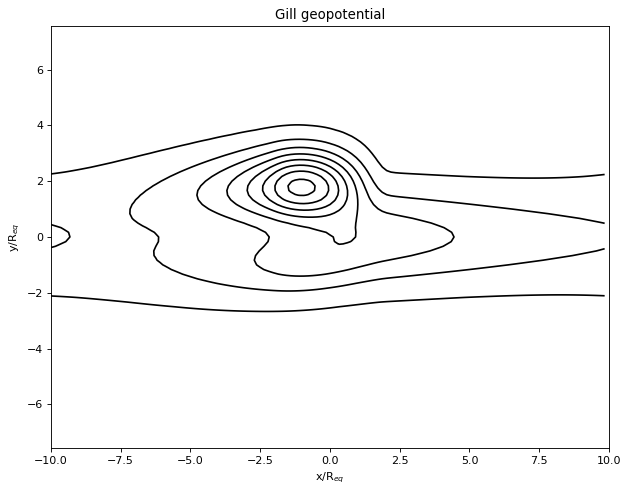

In [21]:
#Next figure: 

#%    Plot Gill phi

plt.figure(3,figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
#plt.subplot(2,1,1) #Don't actually need to do this--only one panel
cphimax = 2 #%Fixed contours (?)
cpos = np.arange(0.1,2.1,0.2)*cphimax

plt.contour(x,y, phi, cpos, colors='k', linestyles='solid')
plt.contour(x,y, phi, np.flip(-1*cpos), colors='k', linestyles='dashed')
plt.axis('equal')
plt.axis([xmin, xmax, ymin, ymax])
plt.xlabel('x/R$_{eq}$')
plt.ylabel('y/R$_{eq}$')
plt.title('Gill geopotential')

#This looks exactly the same as the Python version.

In [ ]:
#spdiags test
testdiag = np.arange(10)+1
testdiags = np.tile(testdiag, [5,1])
print(testdiags)
sparsem = spdiags(testdiags, [-2,-1,0,1,2], 10,10)
print(sparsem)
print(sparsem.todense())
#Appears that, as in Matlab, diagonals on the lower left start at first index,
#while diagonals on the upper right end at the last index.

In [ ]:
#Automatic casting to pre-allocated real array?
areal = np.zeros((6,6))
#areal[4,3] = 1+2j #This gives type error! What about assigning a whole row?
complexarray = np.array([1+2j, 1+1j, 1+2j, 1+2j, 1+2j, 1+2j])
areal[2,:] = complexarray
areal #This gives same warning as above, and discards imaginary part!

In [ ]:
#Try with type
acomplex = np.zeros((6,6)) + 1j*np.zeros((6,6))
acomplex[2,:] = complexarray
acomplex #This works as intended!